In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
!pip install -q fastai2

In [5]:
key = os.environ.get('AZURE_SEARCH_KEY','XXX')

In [6]:
search_images_bing #関数定義を確認

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [8]:
#150個の猫の画像をBingでダウンロード

results = search_images_bing(key, 'cat')
ims = results.attrgot('contentUrl')
ims

(#150) ['https://fit-cats.com/wp-content/uploads/2020/02/cat-relaxing-1024x576.jpg','https://blogs.columbian.com/cat-tales/wp-content/uploads/sites/43/2017/09/Sawyer_DS_1402.jpg','https://www.munchkincatguide.com/wp-content/uploads/2019/01/munchkinduo.jpg','https://static.themoscowtimes.com/image/1360/11/portrait-of-a-cat.jpg','https://www.vets4pets.com/siteassets/species/cat/cat-on-fence.jpg?w=585&scale=down','https://www.hdnicewallpapers.com/Walls/Big/Cat/Lovely_Cat_Baby_Wallpaper.jpg','https://images.unsplash.com/photo-1570450466756-c1c0bc431719?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80','https://img.thrfun.com/img/191/908/what_breed_is_my_cat_16_x3.jpg','https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/12/04/12/zelda.jpg','http://paradoxoff.com/files/2011/02/albino-cat-05.jpg'...]

In [9]:
#一枚だけ取る

ims = ['https://blogs.columbian.com/cat-tales/wp-content/uploads/sites/43/2017/09/Sawyer_DS_1402.jpg']

In [10]:
#一枚だけ取る

dest = 'images/cat.jpg'
download_url(ims[0], dest)

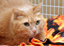

In [12]:
#128×128ピクセルで表示

im = Image.open(dest)
im.to_thumb(64,64)

In [13]:
#3つの種類に分けてフォルダを作る

cat_types = 'persian','scottish fold','american shorthair'
path = Path('cat')

In [14]:
#ループで3つの種類を150枚ずつ取る

if not path.exists():
    path.mkdir()
    for o in cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cat')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [15]:
#ちゃんと入ってるか確認

fns = get_image_files(path)
fns

(#442) [Path('cat/persian/00000047.jpg'),Path('cat/persian/00000055.jpg'),Path('cat/persian/00000061.JPG'),Path('cat/persian/00000107.jpg'),Path('cat/persian/00000097.jpg'),Path('cat/persian/00000145.jpeg'),Path('cat/persian/00000110.jpg'),Path('cat/persian/00000029.jpg'),Path('cat/persian/00000112.jpg'),Path('cat/persian/00000132.JPG')...]

In [16]:
#壊れているか確認、verify_imagesはmapメソッドが適用されている
#4枚、壊れてた

failed = verify_images(fns)
failed

(#0) []

In [17]:
#failedを削除！

failed.map(Path.unlink);

### データからDataLoadersへ
#### DataLoaders はDataLoaderオブジェクトをtrainとvalidで返す
- validはニューラルネットワークのハイパーパラメータの良し悪しを確かめるための検証データ。
<br>

- 今回はfastaiが提供しているDataBlock APIを使う
- 柔軟でステップを細かく触れる

In [18]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

### 独立変数と従属変数を指定
- 独立変数は予測に用いる（画像のセット）、従属変数は予測のターゲットになる（個々のカテゴリ）
<br>

In [19]:
dls = cats.dataloaders(path) #画像が格納されたパスをfastaiに伝える

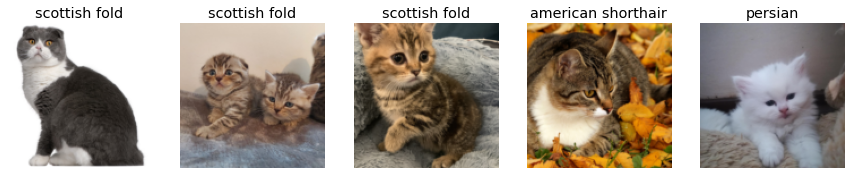

In [20]:
# DataLoaderのshow_batchメソッドで４つ見る

dls.valid.show_batch(max_n=5, nrows=1)

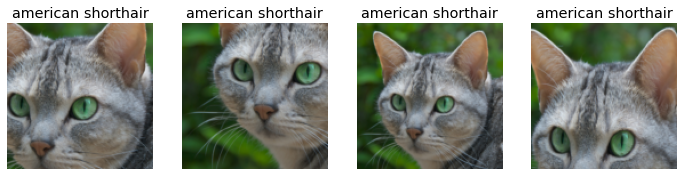

In [21]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3)) # RandomResizeCrop は画像からクロップする部分をランダムに抽出、min_scaleで抽出画面サイズを指定
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True) #UniqueTrueで同じ画像に対してRandomResizeCrop変換を行う

猫可愛い

### これがデータ水増し方法の一例

## データ水増しとは
<br>

#### 入力データにランダムな変換を施す、元のデータとデータとしては別物で意味は変わらない別データを作ること



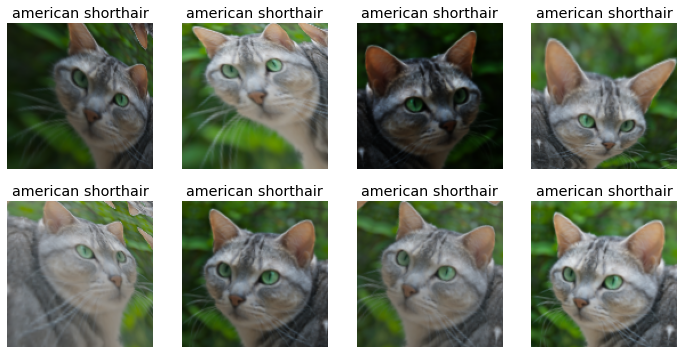

In [22]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) # aug_transform関数 がデータ水増し手法
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## <span style="color: blue; ">モデルが訓練できるようにデータを作ったので、画像クラス識別器を訓練してみる</span>

In [23]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), #sizeを画像クラス分類で標準的に用いられる224ピクセルにする
    batch_tfms=aug_transforms()) #defalutのaug_transformsで訓練
dls = cats.dataloaders(path)

### Learnerでファインチューン

## epoch１回目は何？

In [26]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.677117,0.552001,0.227273,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.629084,0.285050,0.125000,00:12
1,0.440227,0.289028,0.113636,00:11
2,0.359312,0.229866,0.068182,00:12
3,0.292610,0.234670,0.056818,00:12






<br><br>

## アメショとペルシャを間違えてないか、可視化する。

<br>

- この際には混同行列を使う (confusion matrix)

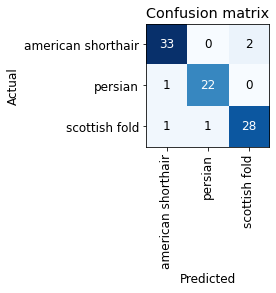

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### 二週目にして使い方が分かってきた模様です
<br>

#### 上の図の対角線上に色が付けられているのは正しく識別できたものでそれ以外にあるところは間違って分類されたもの

<br>

### マンチカンとアメリカンショートヘアは確かに似てます、ちなみに僕は間違えます。

<br><br>

## どの画像でエラーが起きたのか見てみる（ロスの高い画像を引っ張り出す）

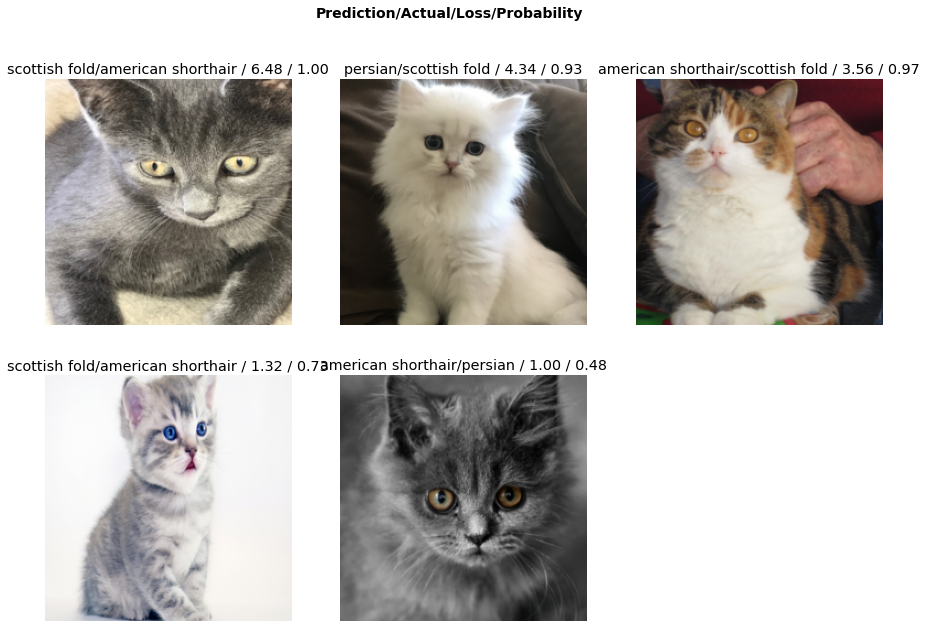

In [28]:
interp.plot_top_losses(5, figsize=(15, 10)) #figsizeは図のサイズ

### Prediction（予測値）Actual（実際のラベル）Loss（ロス）Probability（確率）
<br>

### Probability は予測値に対する確信度のレベル

#### データとして顔、耳、毛質で判断してるのか分かりませんが、とりあえず猫は似すぎですね...

### もう一度訓練するためにデータをクリーニングしたい
<br>

- fastaiはImageClassfierCleaner と呼ばれるGUIベースのデータクリーニングツールを提供している
- カテゴリと訓練セットか検証セットを指定、ロスが大きい順に表示する。
- メニューから削除したりラベル付けを変更したりできる


In [29]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### ここで三匹いたり顔が見にくいものや暗いものはDeleteを選んだ
<br>

- ここでは実際に削除してくれるわけではないのでDeleteを指定したすべての画像を削除するためのコードを書く

In [30]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #for文でdeleteを削除

## データを綺麗にしたので再訓練してみる、、、精度上がれ...

In [31]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), #sizeを画像クラス分類で標準的に用いられる224ピクセルにする
    batch_tfms=aug_transforms()) #defalutのaug_transformsで訓練
dls = cats.dataloaders(path)

In [32]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.640903,0.514902,0.238636,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.760106,0.314641,0.125000,00:12
1,0.548230,0.288920,0.113636,00:12
2,0.440806,0.266262,0.079545,00:11
3,0.349420,0.250223,0.090909,00:12


。。。

## モデルはアーキテクチャとパラメータの2つからできている
<br>

- 2つを保存するためにはexportメソッドを使う

In [33]:
learn.export()

In [34]:
path = Path()
path.ls(file_exts='.pkl') #pathにlsメソッドを使ってファイルがあるか確認

(#1) [Path('export.pkl')]

### ファイルがありましたね

### 保存されたファイルから推論を行うLearnerを作るにはload_learner関数を使う

In [35]:
learn_inf = load_learner(path/'export.pkl')

## 推論を行う

### predictにファイル名を渡す

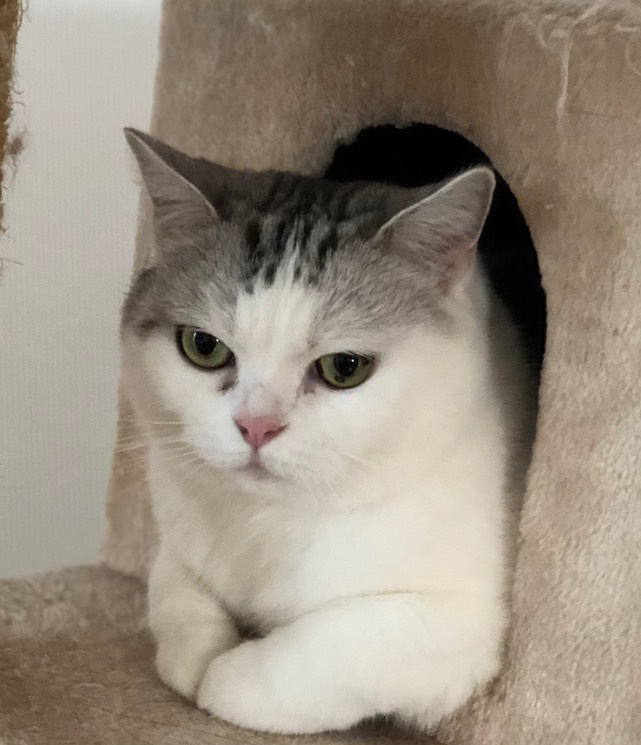

In [36]:
coco = Image.open('images/cat_coco.jpg')
coco

In [37]:
learn_inf.predict('images/cat_coco.jpg')

('scottish fold', TensorImage(2), TensorImage([0.2852, 0.0026, 0.7121]))

In [38]:
learn_inf.dls.vocab

['american shorthair', 'persian', 'scottish fold']